In [1]:
library("ape")
library("phytools")
library("caper")
library("geiger")
library("readxl")
library("tidyverse")

Loading required package: maps

Loading required package: MASS

Loading required package: mvtnorm

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::map()    masks maps::map()
✖ dplyr::select() masks MASS::select()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
load_and_process_csv <- function(csv_filename) {
    df <- read.csv(csv_filename)
    rownames(df) <- df$species
    df$log_u <- log10(df$u_mean)
    df$log_u_year <- log10(df$u_mean_year)
    df$log_Ne <- log10(df$Ne)
    df$log_Ne.gen <- log10(df$Ne.gen)
    df$log_gen_year <- log10(df$generation_time_year)
    df = dplyr::select(df, species, log_u, log_u_year, log_Ne, log_Ne.gen, log_gen_year)
    return(df)
}

load_tree_and_modify_species_name <- function(tree_filename) {
    tree <- read.tree(tree_filename)
    # the tree should be both binary and ultrametric
    stopifnot(is.binary(tree)) 
    stopifnot(is.ultrametric(tree))
    # 126 species, 250 edges
    length(tree$tip.label) 
    # plot(tree)
    
    # replace all _ in tree species name to space
    for(nn in tree$tip.label){
      tmp <- stringr::str_replace_all(nn,'_', ' ')
      tree$tip.label <- 
        stringr::str_replace_all(tree$tip.label, nn, tmp)
    }
    return(tree)
}

trim_tree_branches <- function (tree, df) {
    # trim off tree branches corresponding to species that are not found in the dataframe
    name_check <- name.check(tree, df)
    new_tree <- drop.tip(tree, name_check$tree_not_data)
    name.check(new_tree, df)
    return(new_tree)
}

pgls_dbh <- function(df, tree, x_name, y_name, lambda, print_plot) {
    taxa <- comparative.data(tree, df, "species", vcv=TRUE)
    fm <- as.formula(paste(y_name, "~", x_name))
    model <- pgls(formula=fm, data=taxa, lambda=lambda)
    coeff <- coefficients(model)
    intercept <- coeff[1]
    slope <- coeff[2]
    Ne_u_plot <- ggplot(data=df, aes_string(x=x_name, y=y_name)) + geom_point()
    Ne_u_plot <- Ne_u_plot + geom_abline(intercept = intercept, slope = slope) + geom_smooth(formula=y~x, method="lm")
    if (print_plot) {
        print(Ne_u_plot + labs(y=y_name, x=x_name))
    }

    res<- residuals(model, phylo = TRUE)
    res<- res/sqrt(var(res))[1]
    
    return(model)
}

save_summary_data <- function(model, print_output, save_output, save_filename="output_file.csv") {
    model_summary <- summary(model)
    # names(summary(model_summary))
    lambda <- model_summary$param.CI$lambda$opt
    lambda.ci.val <- model_summary$param.CI$lambda$ci.val
    lambda.bounds <- model_summary$param.CI$lambda$bounds.val
    lambda.p <- model_summary$param.CI$lambda$bounds.p
    
    coeff <- model_summary$coefficients[,1]
    coeff.p <- model_summary$coefficients[,4]
    if (print_output) {
        cat("lambda: ", lambda, ", CI of lambda: ", lambda.ci.val, "\n")
        cat("coefficients: ", coeff, ", p-value: ", coeff.p, "\n")
    }

    if (save_output) {
        df_out <- t(data.frame(c(lambda, lambda.ci.val, lambda.bounds, lambda.p, coeff, coeff.p)))
        colnames(df_out) <- c("lambda", "lambda.ci.low", "lambda.ci.high", "lambda.bounds.low", "lambda.bounds.high", "lambda.p.low", "lambda.p.high", "intercept", "slope", "intercept.p", "slope.p")
        rownames(df_out) <- c(1)
        write.csv(df_out, save_filename)
    }
}

## Load Wang's vertebrate data and tree 

In [3]:
# df <- load_and_process_csv("./output/processed_mutation_rate_estimate.csv")
df <- load_and_process_csv("./output/df_vertebrate.csv")

tree_filename <- "./data/filtered_unique_species.nwk"
tree <- load_tree_and_modify_species_name(tree_filename)
new_tree <- trim_tree_branches(tree, df)

## Figure 3 regression: mutation rate per generation vs generation time

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”



Call:
pgls(formula = fm, data = taxa, lambda = lambda)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08811 -0.01184  0.00137  0.01160  0.06644 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.960
   lower bound : 0.000, p = 0.02006
   upper bound : 1.000, p = 4.563e-14
   95.0% CI   : (0.845, 0.986)
delta  [Fix]  : 1.000

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  -8.296052   0.250083 -33.173 < 2.2e-16 ***
log_gen_year  0.215250   0.076931   2.798  0.006637 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02438 on 70 degrees of freedom
Multiple R-squared: 0.1006,	Adjusted R-squared: 0.08774 
F-statistic: 7.829 on 1 and 70 DF,  p-value: 0.006637 

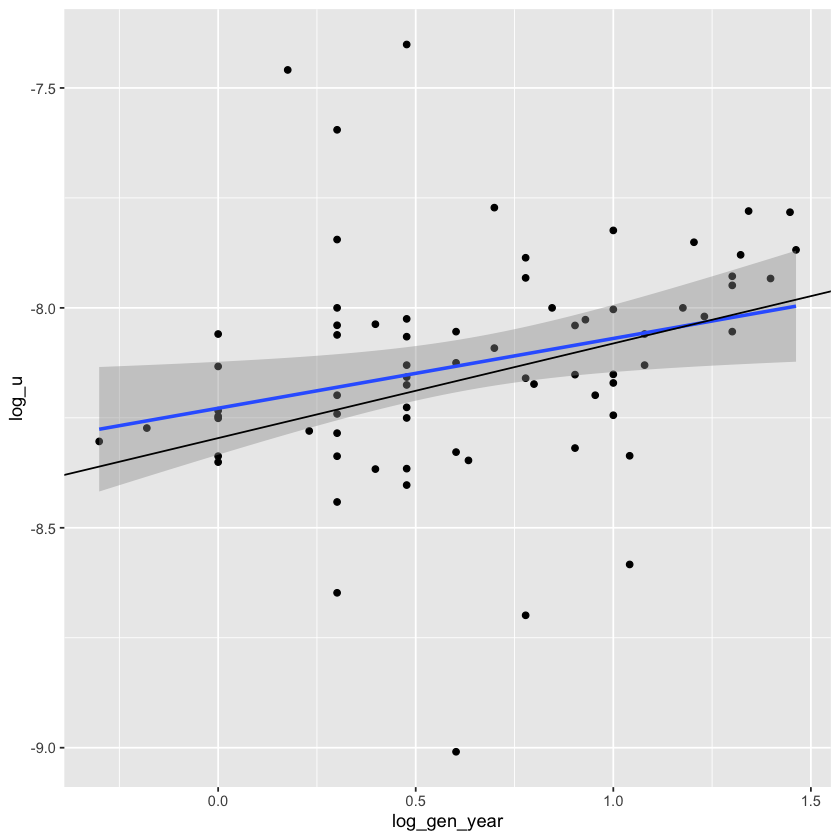

In [5]:
lambda = "ML" 
model.u_gen <- pgls_dbh(df, new_tree, "log_gen_year", "log_u", lambda=lambda, print_plot=TRUE)
summary(model.u_gen)
save_summary_data(model.u_gen, print_output=FALSE, save_output=TRUE, save_filename="output/r/mu_gen_vs_gen.csv")

## Figure 5 regressions

### Panel A: PGLS of effective population size on generation time (year)

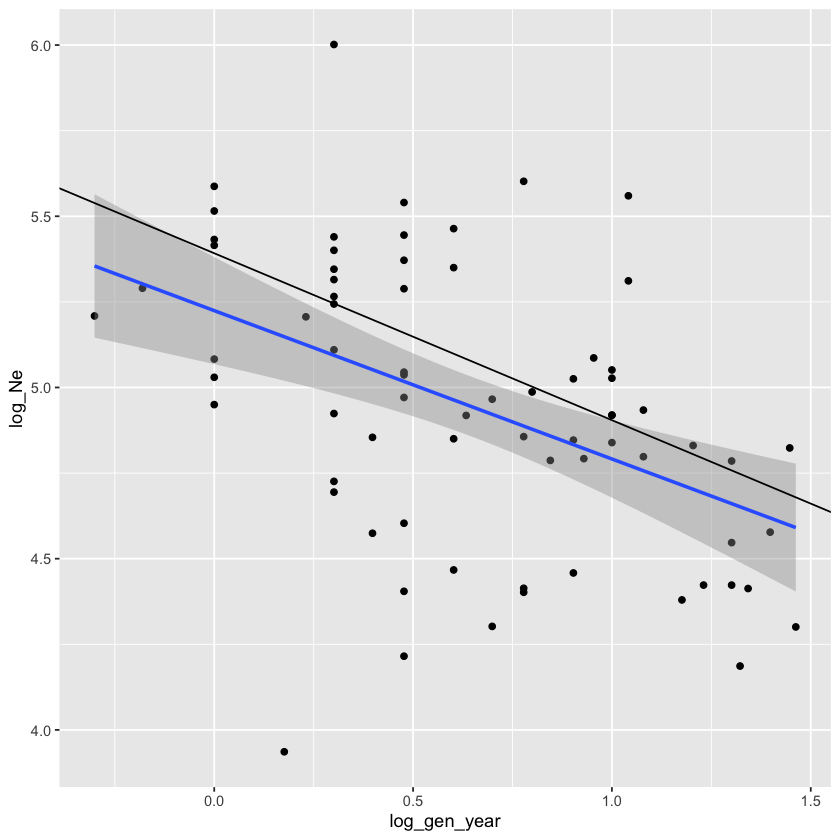

In [6]:
lambda = "ML" 
gen_Ne.pgls <- pgls_dbh(df, new_tree, "log_gen_year", "log_Ne", lambda=lambda, print_plot=TRUE)
# summary(gen_Ne.pgls)
save_summary_data(gen_Ne.pgls, print_output=FALSE, save_output=TRUE, save_filename="output/r/Ne_vs_gen.csv")

### Panel C: perform PGLS of mutation rate per year on Ne * gen  

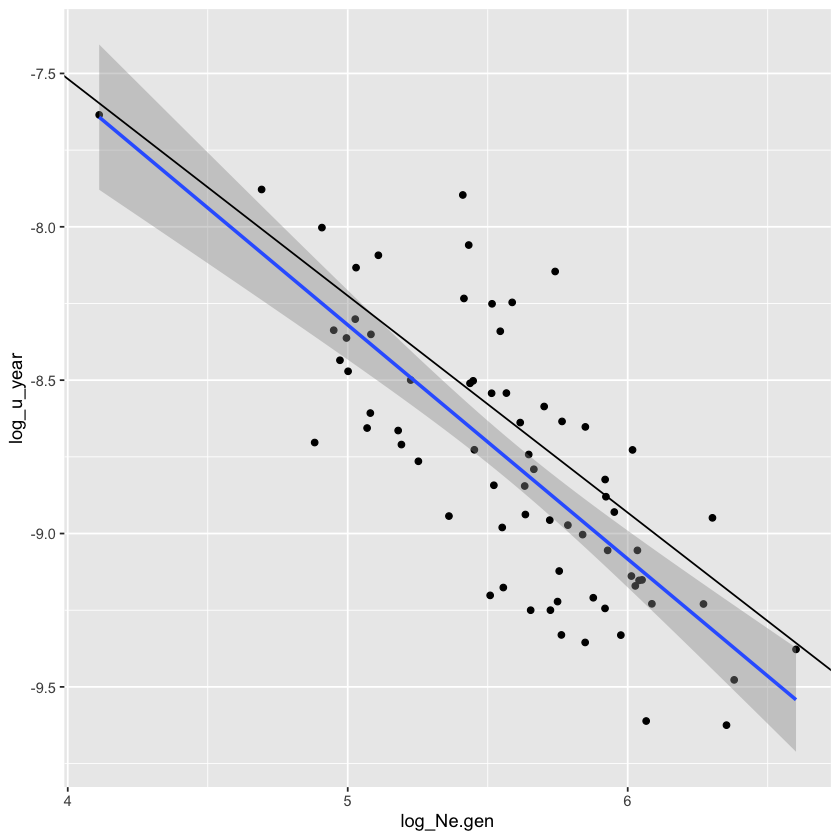

In [7]:
lambda = "ML" 
Negen_u_year.pgls <- pgls_dbh(df, new_tree, "log_Ne.gen", "log_u_year", lambda=lambda, print_plot=TRUE)
# summary(Negen_u.pgls)

print_output=FALSE
save_output=TRUE
save_summary_data(Negen_u_year.pgls, print_output=print_output, save_output=save_output, save_filename="output/r/dbh_vertebrate_u_year_vs_Negen.csv")

## Perform PGLS on gamete mutation rate per site per year and early embryonic mutation rate per site per generation on generation time (year)
Results are reported in figure 2

In [13]:
create_gamete_and_embroynic_mutation_rate_dataframe <- function(csv_filename) {
    # human,  rhesus macaque, owl monkey, cat, mouse, chimpanzee, baboon, aye-aye (gray mouse lemur), dog
    columnHeaders <- c("species", "species2", "gen", "intercept", "slope", "mu_gen")
    # csv_filename <- "output/figure2_point_estimates_Wang_Wang.csv"
    df <- read.csv(csv_filename, header=FALSE, skip=1, col.names=columnHeaders)

    df$log_slope <- log10(df$slope)
    df$log_intercept <- log10(df$intercept)
    df$log_gen <- log10(df$gen)
    df$log_mu_gen <- log10(df$mu_gen)
    rownames(df) <- df$species
    return(df)
}

parse_dataset_name <- function(filename) {
    file_basename <- basename(filename)
    file_no_ext <- strsplit(file_basename, "\\.")[[1]][1]
    file_split <- strsplit(file_no_ext, "_")[[1]]
    dataset_name <- paste(file_split[4], "_", file_split[5], sep="")
    return(dataset_name)
}

parse_alpha_value <- function(filename) {
    file_basename <- basename(filename)
    file_no_ext <- strsplit(file_basename, "\\.")[[1]][1]
    file_split <- strsplit(file_no_ext, "_")[[1]]
    alpha_value <- paste(file_split[6], "_", file_split[7], sep="")
    return(alpha_value)
}

perform_gamete_embroynic_data_regression <- function(filename, lambda, print_output, print_plot) {
    df <- create_gamete_and_embroynic_mutation_rate_dataframe(filename)
    dataset_name <- parse_dataset_name(filename)
    alpha_value <- parse_alpha_value(filename)
    print(dataset_name)
    print(alpha_value)

    tree <- read.tree("./data/filtered_unique_species.nwk")
    model.mu_gamete_gen <- pgls_dbh(df, tree, "log_gen", "log_slope", lambda, print_plot)
    slope_regression_filename <- paste("output/r/longevity_model/", dataset_name, "/mu_gamete_vs_generation_time_", dataset_name, "_", alpha_value, ".csv", sep="")
    save_summary_data(model.mu_gamete_gen, print_output=print_output, save_output=TRUE, save_filename=slope_regression_filename)
    
    model.mu_embryonic_gen <- pgls_dbh(df, tree, "log_gen", "log_intercept", lambda, print_plot)
    intercept_regression_filename <- paste("output/r/longevity_model/", dataset_name, "/mu_embryonic_vs_generation_time_", dataset_name, "_", alpha_value, ".csv", sep="")
    save_summary_data(model.mu_embryonic_gen, print_output=print_output, save_output=TRUE, save_filename=intercept_regression_filename)

    model.mu_per_gen <- pgls_dbh(df, tree, "log_gen", "log_mu_gen", lambda, print_plot)
    per_gen_regression_filename <- paste("output/r/longevity_model/", dataset_name, "/mu_gen_vs_generation_time_", dataset_name, "_", alpha_value, ".csv", sep="")
    save_summary_data(model.mu_per_gen, print_output=print_output, save_output=TRUE, save_filename=per_gen_regression_filename)
}

lambda <- 'ML'
print_output <- TRUE
print_plot <- FALSE
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wang_wang_variable_alpha.csv", lambda, print_output, print_plot)
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wang_wang_default_alpha.csv", lambda, print_output, print_plot)
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wang_versoza_variable_alpha.csv", lambda, print_output, print_plot)
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wu_wang_variable_alpha.csv", lambda, print_output, print_plot)
perform_gamete_embroynic_data_regression("output/figure2_point_estimates_wu_versoza_variable_alpha.csv", lambda, print_output, print_plot)

[1] "wang_wang"
[1] "variable_alpha"
lambda:  1e-06 , CI of lambda:  NA 0.858358 
coefficients:  -8.876337 -0.4411465 , p-value:  4.822018e-10 0.002304049 
lambda:  1e-06 , CI of lambda:  NA 0.8646984 
coefficients:  -8.406738 0.109934 , p-value:  2.172784e-10 0.1384089 
lambda:  1e-06 , CI of lambda:  NA NA 
coefficients:  -8.322187 0.2195834 , p-value:  1.279846e-09 0.05495356 
[1] "wang_wang"
[1] "default_alpha"
lambda:  1e-06 , CI of lambda:  NA 0.8453724 
coefficients:  -8.876225 -0.4392929 , p-value:  4.66863e-10 0.002281015 
lambda:  1e-06 , CI of lambda:  NA 0.8374664 
coefficients:  -8.404643 0.1087092 , p-value:  1.976139e-10 0.1359017 
lambda:  1e-06 , CI of lambda:  NA NA 
coefficients:  -8.319746 0.2192007 , p-value:  1.095134e-09 0.0501376 
[1] "wang_versoza"
[1] "variable_alpha"
lambda:  1e-06 , CI of lambda:  NA 0.8976042 
coefficients:  -8.868048 -0.4450458 , p-value:  6.405565e-10 0.002834751 
lambda:  1 , CI of lambda:  NA NA 
coefficients:  -8.689817 0.253216 , p-va

In [65]:
lambda <- "ML"

files = list.files(path="output/bootstrap_slopes_and_intercepts", pattern="*slopes*", full.names=TRUE, recursive=FALSE)
tree_species_name <- c("Homo_sapiens_neanderthalensis", "Papio_anubis", "Macaca_mulatta_vestita", "Aotus_nancymaae", "Felis_catus", "Mus_musculus_musculus", "Pan_troglodytes", "Microcebus_murinus", "Canis_lupus_familiaris")
generation_time <- c(29, 10, 8, 6.6, 3.8, 0.66, 25, 4, 4)
df_gen = data.frame("gen.time"=generation_time)
rownames(df_gen) <- tree_species_name
tree <- read.tree("./data/filtered_unique_species.nwk")

lapply(files, function(filename) {
    file_basename <- basename(filename)
    file_base_no_ext <- sub('\\.csv$', '', file_basename) 
    temp <- strsplit(file_base_no_ext, "_")
    file_idx <- temp[[1]][3]
    output_filename <- paste("output/r/bootstrap_regression/intercept_embryonic_vs_generation_time_", file_idx, ".csv", sep="")
    df_rate <- read.csv(filename, header=FALSE, skip=1, col.names = c("species", "rate")) #, row.names=1)
    rownames(df_rate) <- df_rate$species
    df <- merge(df_rate, df_gen, by=0)
    df$log_mu <- log10(df$rate)
    df$log_gen <- log10(df$gen.time)
    convergence_error <- 0
    tryCatch(
        {
            model <- pgls_dbh(df, tree, "log_gen", "log_mu", lambda, FALSE)
            save_summary_data(model, print_output=FALSE, save_output=TRUE, save_filename=output_filename)
        },
        error= function(error_message) {
            convergence_error <- convergence_error + 1
        })
    # df$log_Ne <- log10(df$Ne)
    # df$log_Ne.gen <- log10(df$Ne.gen)
    # df$log_gen_year <- log10(df$generation_time_year)
    # df = dplyr::select(df, species, log_u, log_u_year, log_Ne, log_Ne.gen, log_gen_year)
    # return(df)
})
print(convergence_error)

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
[1] 1

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
[1] 1

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
[1] 1

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
NULL

[[103]]
NULL

[[104]]
NULL

[[105]]
NULL

[[106]]
NULL

[[107]]
NULL

[[108]]
NULL

[[109]]
NULL

[[110]]
NULL

[[111]]
NULL

[[112]]
NULL

[[113]]
NULL

[[114]]
NULL

[[115]]
NULL

[[116]]
NULL

[[117]]
NULL

[[118]]
NULL

[[119]]
NULL

[[120]]
NULL

[[121]]
NULL

[[122]]
NULL

[[123]]
NULL

[[124]]
NULL

[[125]]
NULL

[[126]]
NULL

[[127]]
NULL

[[128]]
NULL

[[129]]
NULL

[[130]]
NULL

[[131]]
NULL

[[132]]
NULL

[[133]]
NULL

[[134]]
[1] 1

[[135]]
NULL

[[136]]
NULL

[[137]]
NULL

[[138]]
NULL

[[139]]
NULL

[[140]]
NULL

[[141]]
[1] 1

[[142]]
NULL

[[143]]
NULL

[[144]]
NULL

[[145]]
NULL

[[146]]
[1] 1

[[147]]
[1] 1

[[148]]
NULL

[[149]]
NULL

[[150]]
NULL

[[151]]
NULL

[[152]]
NULL

[[153]]
NULL

[[154]]
NULL

[[155]]
NULL

[[156]]
NULL

[[157]]
NULL

[[158]]
NULL

[[159]]
NULL

[[160]]
NULL

[[161]]
NULL

[[162]]
NULL

[[163]]
NULL

[[164]]
NULL

[[165]]
NULL

[[166]]
NULL

[[167]]
NULL

[[168]]
NULL

[[169]]
NULL

[[170]]
NULL

[[171]]
NULL

[[172]]
NULL

[[173]]
NULL

[[174]]
NULL

[[175]]
NULL

[[176]]
NULL

[[177]]
NULL

[[178]]
NULL

[[179]]
NULL

[[180]]
NULL

[[181]]
NULL

[[182]]
NULL

[[183]]
NULL

[[184]]
NULL

[[185]]
NULL

[[186]]
NULL

[[187]]
NULL

[[188]]
NULL

[[189]]
NULL

[[190]]
NULL

[[191]]
NULL

[[192]]
NULL

[[193]]
NULL

[[194]]
NULL

[[195]]
NULL

[[196]]
NULL

[[197]]
NULL

[[198]]
NULL

[[199]]
NULL

[[200]]
NULL

[[201]]
NULL

[[202]]
NULL

[[203]]
NULL

[[204]]
NULL

[[205]]
NULL

[[206]]
NULL

[[207]]
NULL

[[208]]
NULL

[[209]]
NULL

[[210]]
NULL

[[211]]
NULL

[[212]]
NULL

[[213]]
NULL

[[214]]
NULL

[[215]]
NULL

[[216]]
NULL

[[217]]
NULL

[[218]]
NULL

[[219]]
NULL

[[220]]
NULL

[[221]]
NULL

[[222]]
NULL

[[223]]
NULL

[[224]]
NULL

[[225]]
NULL

[[226]]
NULL

[[227]]
NULL

[[228]]
NULL

[[229]]
NULL

[[230]]
NULL

[[231]]
NULL

[[232]]
NULL

[[233]]
NULL

[[234]]
NULL

[[235]]
NULL

[[236]]
[1] 1

[[237]]
NULL

[[238]]
NULL

[[239]]
NULL

[[240]]
NULL

[[241]]
NULL

[[242]]
NULL

[[243]]
NULL

[[244]]
NULL

[[245]]
NULL

[[246]]
NULL

[[247]]
NULL

[[248]]
NULL

[[249]]
NULL

[[250]]
NULL

[[251]]
NULL

[[252]]
NULL

[[253]]
NULL

[[254]]
NULL

[[255]]
NULL

[[256]]
NULL

[[257]]
NULL

[[258]]
NULL

[[259]]
NULL

[[260]]
NULL

[[261]]
NULL

[[262]]
NULL

[[263]]
NULL

[[264]]
NULL

[[265]]
NULL

[[266]]
[1] 1

[[267]]
NULL

[[268]]
NULL

[[269]]
NULL

[[270]]
NULL

[[271]]
NULL

[[272]]
NULL

[[273]]
NULL

[[274]]
NULL

[[275]]
NULL

[[276]]
[1] 1

[[277]]
NULL

[[278]]
NULL

[[279]]
NULL

[[280]]
NULL

[[281]]
NULL

[[282]]
NULL

[[283]]
NULL

[[284]]
NULL

[[285]]
NULL

[[286]]
NULL

[[287]]
NULL

[[288]]
NULL

[[289]]
NULL

[[290]]
NULL

[[291]]
NULL

[[292]]
NULL

[[293]]
NU

ERROR: Error in print(convergence_error): object 'convergence_error' not found
